In [1]:
%load_ext autoreload
%autoreload 2

from data.projectionsdataset import ProjectionsDataset
from data.emdataset import EMDataset
import matplotlib.pyplot as plt 
from tifffile import imread
from PIL import Image
from tqdm import tqdm
import open3d as o3d
import numpy as np
import torchvision
import importlib
import warnings
import mrcfile
import astra
import torch
import os
import PIL

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
data_path = "data/Au_Ag" 
projections_path = os.path.join(data_path, "Serie_3_ali.tif")
angles_path = os.path.join(data_path, "TiltAngle_ali.txt")
mrc_path = os.path.join(data_path, "Serie_3.mrc")

In [3]:
def get_n_channels(mode):
    return {
        "1": 1,  
        "L": 1,  
        "P": 1,  
        "RGB": 3,  
        "RGBA": 4,  
        "CMYK": 4,  
        "YCbCr": 3,  
        "I": 1,  
        "F": 1,  
    }.get(mode, 1)  
    
def read_tif(filepath) -> torch.Tensor: 

    with Image.open(filepath) as im:

        if im.mode != "L":
            print(f"Image mode ({im.mode}) different than the expected 'L' (8-bit grayscale) this may lead to improper processing")

        n_channels = get_n_channels(im.mode)
        tensor_shape = (im.n_frames, n_channels, im.height, im.width)
        image_tensor = torch.zeros(tensor_shape, dtype=torch.uint8) 

        for i in range(im.n_frames):
            im.seek(i)

            np_array = np.array(im) 
        
            if n_channels == 1:
                np_array = np.expand_dims(np_array, axis=-1) 
            
            image_tensor[i] = torch.from_numpy(np_array).permute(2, 0, 1) 
            
        return image_tensor 

def read_angles_file(filepath: str) -> torch.Tensor:
    with open(filepath, 'r') as file:
        lines = file.readlines()
    
    return torch.from_numpy( np.array([float(line.strip()) for line in lines], dtype=np.float32) )


def estimate_memory(n, size, channels=1, dtype=torch.uint8):

    bytes_per_pixel = torch.tensor([], dtype=dtype).element_size()
    
    memory_per_image = size[0] * size[1] * channels * bytes_per_pixel
    
    total_memory_bytes = n * memory_per_image
    
    print( f"Storing this object uses: {total_memory_bytes / 1024**2} MB of memory" )

def tensor_memory_usage(tensor: torch.Tensor) -> float:
    num_elements = tensor.numel()
    element_size = tensor.element_size()
    total_size_in_bytes = num_elements * element_size
    print( f"Storing this tensor uses: {total_size_in_bytes / 1024**2} MB of memory" )


In [4]:
images_tensor = read_tif(projections_path)

In [5]:
# plt.imshow(  images_tensor[50].permute(1, 2, 0), cmap="Greys_r" )

In [6]:
# plt.imshow(  images_tensor[50].permute(1, 2, 0), cmap="Greys_r" )

In [7]:
angles = read_angles_file(angles_path)

In [8]:
def get_vram_info():
    total_vram = torch.cuda.get_device_properties(0).total_memory
    allocated_vram = torch.cuda.memory_allocated(0)
    free_vram = total_vram - allocated_vram
    return total_vram, allocated_vram, free_vram

In [9]:
dataset = EMDataset("cpu", projections_path, angles_path)

/home/multari/temnerf/src/data/emdataset.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(origins, dtype=torch.float32),
/home/multari/temnerf/src/data/emdataset.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(directions, dtype=torch.float32),


In [25]:

# plt.imshow(  dataset.images_tensor[50].permute(1, 2, 0), cmap="Greys_r" )

In [11]:
def plot_rays(origins, directions, scale = 0.1, show_dir=False):
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(origins)
    
    geometries = [point_cloud]
    if show_dir:
        lines = []
        line_points = []

        for origin, direction in zip(origins, directions):
            end_point = origin + scale * direction
            line_points.append(origin)
            line_points.append(end_point)
            lines.append([len(line_points) - 2, len(line_points) - 1])

        line_points = np.array(line_points)
        lines = np.array(lines)

        line_set = o3d.geometry.LineSet()
        line_set.points = o3d.utility.Vector3dVector(line_points)
        line_set.lines = o3d.utility.Vector2iVector(lines)

        geometries.append(line_set)

    o3d.visualization.draw_geometries(geometries)

In [12]:
def read_tif(file_path):
    return imread(file_path)

def read_angles_file(file_path):
    return np.loadtxt(file_path)


data_path = "data/Au_Ag"
projections_path = os.path.join(data_path, "Serie_3_ali.tif")
angles_path = os.path.join(data_path, "TiltAngle_ali.txt")


images_tensor = read_tif(projections_path)
angles_tensor = np.deg2rad(read_angles_file(angles_path))


angles_tensor = np.array(angles_tensor).flatten()


num_projections = images_tensor.shape[0]

detector_size_y = images_tensor.shape[1]
detector_size_x = images_tensor.shape[2]

vol_size = images_tensor.shape[1]


images_tensor = np.transpose(images_tensor, (1, 0, 2))


vol_geom = astra.create_vol_geom(vol_size, vol_size, vol_size)
proj_geom = astra.create_proj_geom('parallel3d', 1.0, 1.0, detector_size_y, detector_size_x, angles_tensor)


sinogram_id = astra.data3d.create('-sino', proj_geom, images_tensor)
projector_id = astra.create_projector('cuda3d', proj_geom, vol_geom)

vectors = astra.geom_2vec(proj_geom)["Vectors"]

In [13]:
def create_geometry_vectors(angles, detector_spacing_X=1.0, detector_spacing_Y=1.0):

    vectors = np.zeros((len(angles), 12))
    for i in range(len(angles)):

        # ray direction
        vectors[i, 0] = np.sin(angles[i])
        vectors[i, 1] = -np.cos(angles[i])
        vectors[i, 2] = 0

        # center of detector
        vectors[i, 3] = 0
        vectors[i, 4] = 0
        vectors[i, 5] = 0

        # vector from detector pixel (0,0) to (0,1)
        vectors[i, 6] = np.cos(angles[i]) * detector_spacing_X
        vectors[i, 7] = np.sin(angles[i]) * detector_spacing_X
        vectors[i, 8] = 0

        # vector from detector pixel (0,0) to (1,0)
        vectors[i, 9] = 0
        vectors[i, 10] = 0
        vectors[i, 11] = detector_spacing_Y

    return vectors

In [14]:
vectors = create_geometry_vectors(angles_tensor)

In [15]:
# vectors = astra.geom_2vec(proj_geom)["Vectors"]


In [16]:
def compute_ray(vec, u, v, factor=10):

    ray_direction = vec[:3]
    det_center    = vec[3:6]
    width_vec     = vec[6:9]
    height_vec    = vec[9:12]

    pixel_location = det_center + u * width_vec + v * height_vec # pixel location on the projection
    ray_origin = pixel_location + ray_direction * factor         # the origin of the ray is the pixel location translated by the direction times a factor away
    return ray_origin, -ray_direction

size = 1024 # size of the projection
n_proj = 75  # number of projections

# origins    = np.zeros((n_proj, size, size, 3))
# directions = np.zeros((n_proj, size, size, 3))

# for p in range(n_proj):
#     for i in range(-size//2,size//2):
#         for j in range(-size//2, size//2):
#             origins[p, i, j], directions[p, i, j] = compute_ray(vectors[p], i, j)



# origins_reshaped = origins.reshape(-1, 3)
# directions_reshaped = directions.reshape(-1, 3)

# plot_rays(origins_reshaped, directions_reshaped, scale=1, show_dir=False)

In [17]:
def compute_rays(vecs, size, factor=(size * np.sqrt(3)) / 2):
    u, v = np.meshgrid(np.arange(-size//2, size//2), np.arange(-size//2, size//2), indexing='ij')
    u = u.reshape(-1)
    v = v.reshape(-1)
    
    origins = np.zeros((vecs.shape[0], size*size, 3))
    directions = np.zeros((vecs.shape[0], size*size, 3))
    
    for p in range(vecs.shape[0]):
        ray_direction = vecs[p, :3]
        det_center = vecs[p, 3:6]
        width_vec = vecs[p, 6:9]
        height_vec = vecs[p, 9:12]
        
        pixel_locations = det_center + u[:, None] * width_vec + v[:, None] * height_vec
        origins[p] = pixel_locations + ray_direction * factor
        directions[p] = -ray_direction
    
    return origins.reshape(-1, 3), directions.reshape(-1, 3)

size = 1024  # size of the projection
n_proj = 75  # number of projections

# origins_reshaped, directions_reshaped = compute_rays(vectors, size)



In [18]:
@torch.no_grad
def compute_rays_torch(vecs, size, factor=None):
    if factor is None:
        factor = (size * np.sqrt(3)) / 2
        
    u, v = torch.meshgrid(torch.arange(-size//2, size//2), torch.arange(-size//2, size//2), indexing='ij')
    u = u.reshape(-1)
    v = v.reshape(-1)
    
    vecs = torch.tensor(vecs, dtype=torch.float64)
    n_projections = vecs.shape[0]

    origins = torch.zeros((n_projections, size * size, 3), dtype=torch.float64)
    directions = torch.zeros((n_projections, size * size, 3), dtype=torch.float64)
    
    for p in range(n_projections):
        ray_direction = vecs[p, :3]
        det_center = vecs[p, 3:6]
        width_vec = vecs[p, 6:9]
        height_vec = vecs[p, 9:12]
        
        pixel_locations = det_center + u[:, None] * width_vec + v[:, None] * height_vec
        origins[p] = pixel_locations + ray_direction * factor
        directions[p] = -ray_direction
    
    return origins.reshape(-1, 3), directions.reshape(-1, 3)

origins_reshaped, directions_reshaped = compute_rays_torch(vectors, size)

In [19]:
# plot_rays(np.asarray(origins_reshaped), np.asarray(directions_reshaped), scale=1, show_dir=False)

In [20]:


origins_reshaped[0]

tensor([-1023.9610,    -8.9360,  -512.0000], dtype=torch.float64)

In [22]:
pix_vals = dataset.images_tensor.permute(0, 2, 3, 1).reshape(-1, dataset.images_tensor.shape[1])

In [34]:
dataset.data[:1024*1024, 6]

1048576

In [46]:
tmp = torch.tensor(images_tensor, dtype=torch.float64)/ 255.0
tmp = tmp.permute(1, 0, 2)

In [47]:
tmp.shape

torch.Size([75, 1024, 1024])

In [57]:
tmp[0]

torch.Size([1048576])

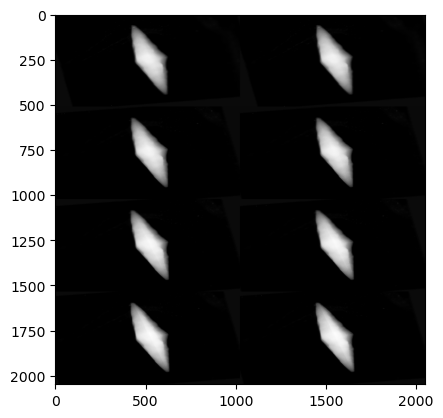

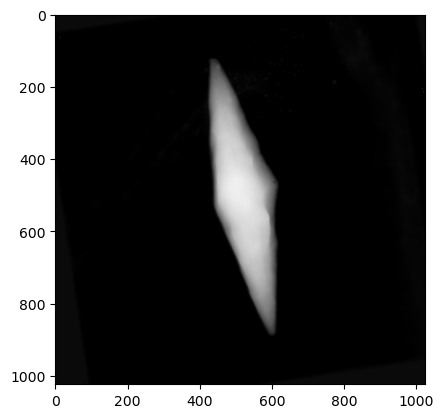

In [80]:
idx = 74
im_s = 1024*1024
plt.imshow(dataset.data[idx*im_s:idx*im_s+im_s, 6].reshape(1024, 1024), cmap='Greys_r')
plt.show()
plt.imshow(tmp[idx].reshape(1024, 1024), cmap='Greys_r')
plt.show()

In [60]:
diff_indices = (dataset.data[:1024*1024, 6] != tmp[0].flatten()).nonzero(as_tuple=True)[0]

print(len(diff_indices))  # Output: tensor([1, 3])

307370
